# Tutorial: Annealed Sinkhorn for Optimal Transport

This notebook explores the concepts presented in the paper "[Annealed Sinkhorn for Optimal Transport: convergence, regularization path and debiasing](https://arxiv.org/pdf/2408.11620)" by Lénaïc Chizat, published in 2024. We will use the `ott-jax` library and manual implementations to understand:

1.  **Standard Sinkhorn:** The baseline algorithm for solving entropy-regularized Optimal Transport (OT) and its speed-accuracy trade-off controlled by the regularization parameter `epsilon` (or `beta = 1/epsilon`).
2.  **Annealed Sinkhorn:** A variant where `beta` increases over iterations (`epsilon` decreases) according to a schedule, aiming to improve the trade-off.
3.  **Debiased Annealed Sinkhorn:** A modification proposed in the paper to mitigate a specific "relaxation error" associated with annealing, potentially allowing for faster convergence schedules.

We will reproduce some key plots and visualizations from the paper.

## 1. Setup and Problem Definition

First, let's import the necessary libraries and set up a basic Optimal Transport problem. We'll use two point clouds in 2D.


In [ ]:
import jax
import jax.numpy as jnp
import jax.scipy as jsp       # For logsumexp in manual implementations
import numpy as np
import matplotlib.pyplot as plt
import ot                     # POT library for exact EMD solver and cost matrix calculation

from ott.geometry import pointcloud, geometry
from ott.problems.linear import linear_problem
from ott.solvers.linear import sinkhorn
from ott.tools import plot

Setup: 100 source points, 120 target points in 2D.


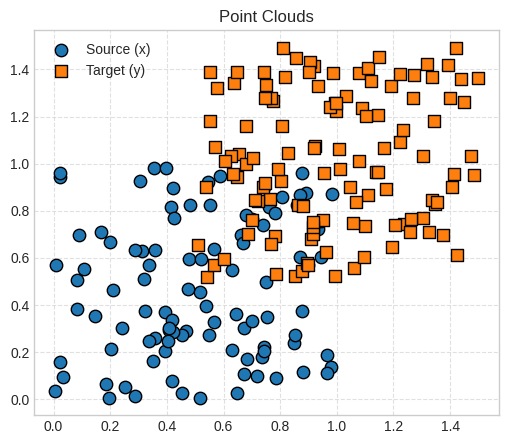

In [ ]:
key = jax.random.PRNGKey(0)

# Define the problem parameters: number of points (m, n) and dimension (d).

m = 100 # Number of source points
n = 120 # Number of target points
d = 2   # Dimension of the points

key, k1, k2 = jax.random.split(key, 3)

# Generate random point clouds
x_data = jax.random.uniform(k1, (m, d))
y_data = jax.random.uniform(k2, (n, d)) + 0.5 # Shift target points

# Define marginal distributions (uniform)
p_jax = jnp.ones(m) / m
q_jax = jnp.ones(n) / n

x_data_np = np.array(x_data, dtype=np.float64)
y_data_np = np.array(y_data, dtype=np.float64)
p_np = np.array(p_jax, dtype=np.float64)
q_np = np.array(q_jax, dtype=np.float64)

print(f"Setup: {m} source points, {n} target points in {d}D.")

# Visualize the initial point clouds
plt.figure(figsize=(6, 5))
plt.scatter(x_data[:, 0], x_data[:, 1], label='Source (x)', edgecolor="k", marker="o", s=80) 
plt.scatter(y_data[:, 0], y_data[:, 1], label='Target (y)', edgecolor="k", marker="s", s=80)
plt.title('Point Clouds')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

We also need the cost matrix (squared Euclidean distance) and the exact OT cost (using the EMD solver from POT) as a reference baseline.

In [ ]:
# Calculate the cost matrix (squared Euclidean distance)
cost_matrix_np = ot.dist(x_data_np, y_data_np, metric='sqeuclidean')
cost_matrix_jax = jnp.array(cost_matrix_np)

# Calculate the exact OT cost using the Earth Mover's Distance (EMD): as the ground truth OT(p, q)
ot_cost_exact = ot.emd2(p_np, q_np, cost_matrix_np)
print(f"Exact OT cost (EMD): {ot_cost_exact:.6f}")

Exact OT cost (EMD): 0.523176


## 2. Standard Sinkhorn Algorithm

The standard Sinkhorn algorithm solves the entropy-regularized OT problem:
$$ \min_{\pi \in \Gamma(p, q)} \langle C, \pi \rangle + \epsilon \text{KL}(\pi | pq^T) $$
where $\epsilon > 0$ is the regularization strength (or `beta = 1/epsilon` is the inverse temperature).

The choice of `epsilon` controls a fundamental **speed-accuracy trade-off**:
*   **Small `epsilon` (Large `beta`):** The solution is closer to the true OT plan, but convergence is slow.
*   **Large `epsilon` (Small `beta`):** Convergence is fast, but the solution is heavily regularized (blurred) and far from the true OT plan.

Let's analyze this trade-off using the `ott-jax` solver. We'll run Sinkhorn for various `epsilon` values and record the number of iterations (speed) and the final regularized cost (related to accuracy).


Analyzing Sinkhorn Speed-Accuracy Trade-off:
Running for epsilon=0.001 (beta=1000.0)
	 * Converged: False
 	 * Didn't reach threshold 0.0001 in 2000 iterations.
 	 * Regularized cost: 0.527
Running for epsilon=0.005 (beta=200.0)
	 * Converged: True
 	 * Reached threshold 0.0001 in 400 iterations.
 	 * Regularized cost: 0.541
Running for epsilon=0.010 (beta=100.0)
	 * Converged: True
 	 * Reached threshold 0.0001 in 210 iterations.
 	 * Regularized cost: 0.554
Running for epsilon=0.050 (beta=20.0)
	 * Converged: True
 	 * Reached threshold 0.0001 in 50 iterations.
 	 * Regularized cost: 0.622
Running for epsilon=0.100 (beta=10.0)
	 * Converged: True
 	 * Reached threshold 0.0001 in 30 iterations.
 	 * Regularized cost: 0.671
Running for epsilon=0.500 (beta=2.0)
	 * Converged: True
 	 * Reached threshold 0.0001 in 10 iterations.
 	 * Regularized cost: 0.780


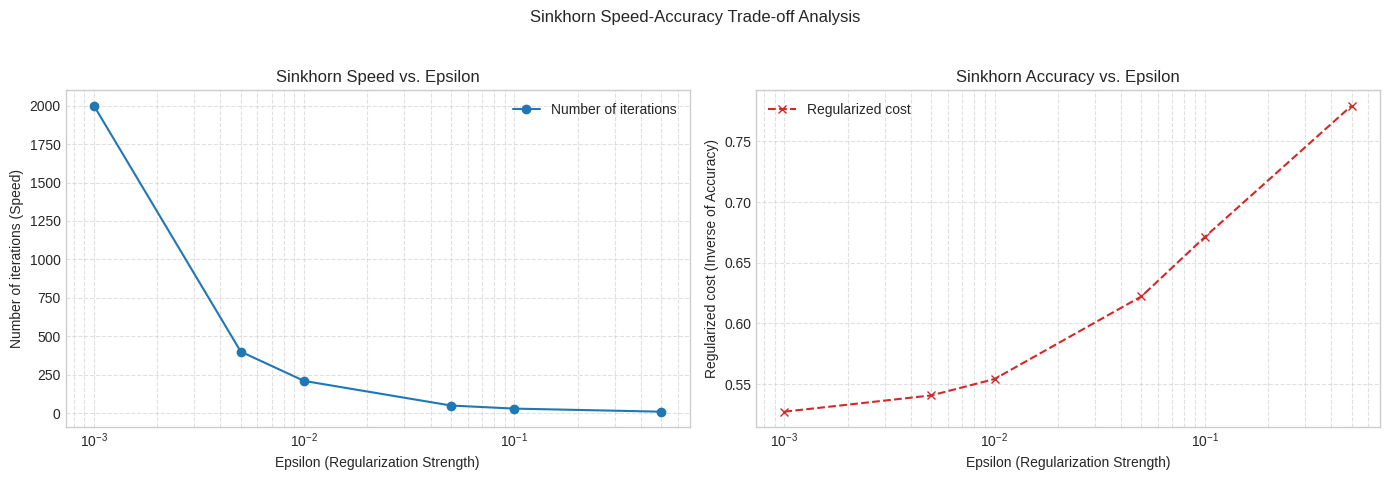

In [ ]:
from ott.solvers.linear import sinkhorn
from ott.problems.linear import linear_problem

thsld = 1e-4 # Convergence threshold
epsilons_tradeoff = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
list_iterations = []
list_cost = []

print("Analyzing Sinkhorn Speed-Accuracy Trade-off:")
for eps in epsilons_tradeoff:
    print(f"Running for epsilon={eps:.3f} (beta={1/eps:.1f})")
    # Create geometry with the current epsilon
    geom_eps = pointcloud.PointCloud(x_data, y_data, epsilon=eps, cost_matrix=cost_matrix_jax)
    ot_prob = linear_problem.LinearProblem(geom=geom_eps, a=p_jax, b=q_jax)

    solver = sinkhorn.Sinkhorn(threshold=thsld)
    output = solver(ot_prob)

    if not output.converged:
        print(f"\t * Converged: {output.converged}\n \t"
            f" * Didn't reach threshold {thsld} in {output.n_iters} iterations.\n \t"
            f" * Regularized cost: {float(output.reg_ot_cost):.3f}")
    else:
        print(f"\t * Converged: {output.converged}\n \t"
            f" * Reached threshold {thsld} in {output.n_iters} iterations.\n \t"
            f" * Regularized cost: {float(output.reg_ot_cost):.3f}")

    list_iterations.append(output.n_iters)
    list_cost.append(float(output.reg_ot_cost))

# Plot the trade-off
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5)) 

ax1.plot(epsilons_tradeoff, list_iterations, label="Number of iterations", marker='o', linestyle='-', color='tab:blue')
ax1.set_xlabel("Epsilon (Regularization Strength)")
ax1.set_ylabel("Number of iterations (Speed)")
ax1.set_title(f"Sinkhorn Speed vs. Epsilon")
ax1.set_xscale('log')
ax1.legend()
ax1.grid(True, which="both", ls="--", alpha=0.6)

ax2.plot(epsilons_tradeoff, list_cost, label="Regularized cost", marker='x', linestyle='--', color='tab:red')
ax2.set_xlabel("Epsilon (Regularization Strength)")
ax2.set_ylabel("Regularized cost (Inverse of Accuracy)")
ax2.set_title(f"Sinkhorn Accuracy vs. Epsilon")
ax2.set_xscale('log')
ax2.legend()
ax2.grid(True, which="both", ls="--", alpha=0.6)

plt.suptitle("Sinkhorn Speed-Accuracy Trade-off Analysis")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

The plots clearly show the trade-off: smaller `epsilon` requires more iterations but yields a lower (better) regularized cost.

### 2.1 Standard Sinkhorn Convergence Trajectories

To compare with Annealed Sinkhorn later, we need to track the *suboptimality* of the iterates over time. The suboptimality is defined as $\langle C, \pi_t^{\text{proj}} \rangle - OT(p, q)$, where $\pi_t^{\text{proj}}$ is the projection of the current iterate $\pi_t$ onto the feasible transport polytope $\Gamma(p, q)$. This projection ensures we measure the cost of a valid transport plan that approximates the current iterate.

We'll implement the projection function (Algorithm 2 in the paper) and a function to run Sinkhorn while tracking this suboptimality. We'll use the Log-Sum-Exp (LSE) mode for stability, implemented manually to mirror the Annealed versions later.



Running Standard Sinkhorn LSE trajectory for Epsilon: 0.0500
Running Standard LSE Mode trajectory with epsilon=0.0500

Running Standard Sinkhorn LSE trajectory for Epsilon: 0.0100
Running Standard LSE Mode trajectory with epsilon=0.0100

Running Standard Sinkhorn LSE trajectory for Epsilon: 0.0050
Running Standard LSE Mode trajectory with epsilon=0.0050

Running Standard Sinkhorn LSE trajectory for Epsilon: 0.0010
Running Standard LSE Mode trajectory with epsilon=0.0010


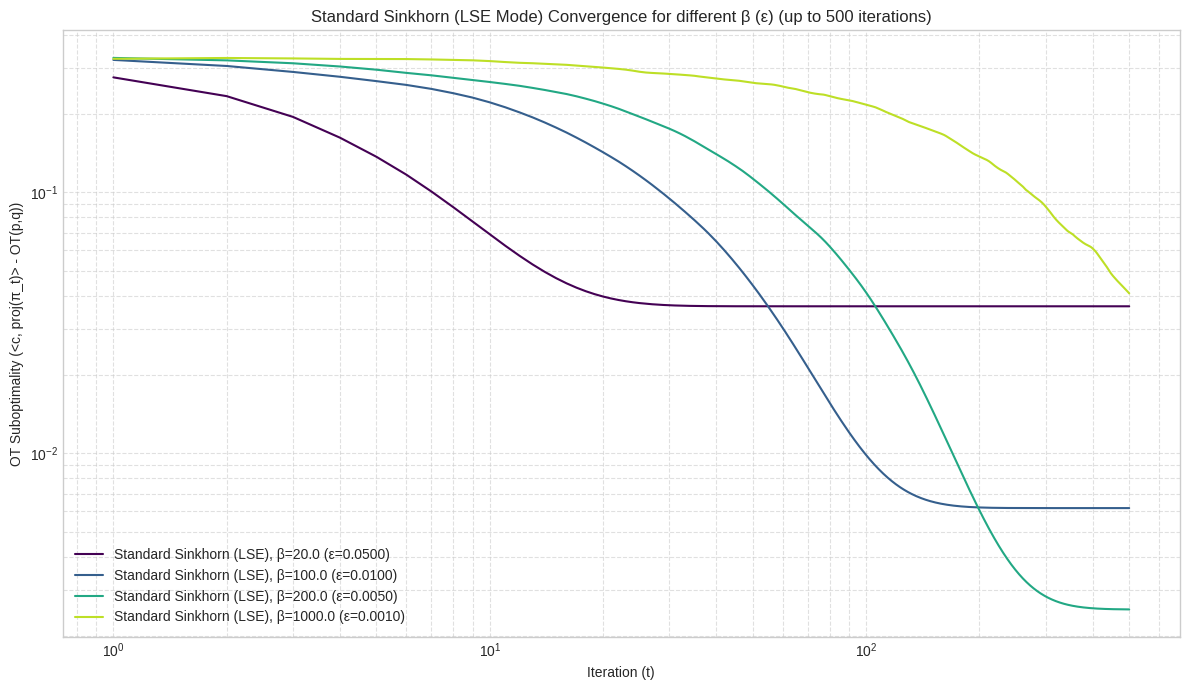

In [ ]:
# --- Projection Function (Algorithm 2) ---
@jax.jit
def project_plan(pi, p, q):
    """Projects a matrix pi onto the set of transport plans Gamma(p, q)."""
    m, n = pi.shape
    p = p.astype(pi.dtype)
    q = q.astype(pi.dtype)
    epsilon_proj = 1e-9 # Small value to avoid division by zero

    # Ensure non-negativity (not needed if pi comes from Sinkhorn)
    pi = jnp.maximum(0.0, pi)

    # Step (a): Adjust rows to match p (approximately)
    pi_1 = pi @ jnp.ones(n) # Row sums
    a = jnp.minimum(1.0, p / (pi_1 + epsilon_proj))
    pi_prime = jnp.diag(a) @ pi

    # Step (b): Adjust columns to match q (approximately)
    pi_prime_T_1 = jnp.ones(m) @ pi_prime # Column sums
    b = jnp.minimum(1.0, q / (pi_prime_T_1 + epsilon_proj))
    pi_double_prime = pi_prime @ jnp.diag(b)

    # Step (c): Distribute residual mass
    delta_p = p - pi_double_prime @ jnp.ones(n)
    delta_q = q - jnp.ones(m) @ pi_double_prime
    # Ensure residuals are non-negative (due to potential floating point errors)
    delta_p = jnp.maximum(0.0, delta_p)
    delta_q = jnp.maximum(0.0, delta_q)
    delta_p_norm1 = jnp.sum(delta_p)

    # Add correction term (outer product of residuals)
    # Only if there's residual mass to distribute
    correction = jnp.where(
        delta_p_norm1 > epsilon_proj,
        jnp.outer(delta_p, delta_q) / delta_p_norm1,
        jnp.zeros_like(pi)
    )
    pi_proj = pi_double_prime + correction

    # Final enforcement of non-negativity
    pi_proj = jnp.maximum(0.0, pi_proj)
    return pi_proj

# --- Function to run Standard Sinkhorn (LSE Mode) and track suboptimality ---
def run_sinkhorn_lse_standard(geom, p, q, cost_matrix, ot_cost_exact, max_iterations):
    """Runs standard Sinkhorn in LSE mode and returns suboptimality trajectory."""
    suboptimalities = []
    m, n = geom.shape
    epsilon = geom.epsilon
    f = jnp.zeros(m, dtype=geom.dtype) # Dual potential for source
    g = jnp.zeros(n, dtype=geom.dtype) # Dual potential for target

    # Precompute log marginals for LSE updates
    log_p = jnp.log(jnp.where(p > 0, p, 1.0)) # Use log(1)=0 for p_i=0
    log_q = jnp.log(jnp.where(q > 0, q, 1.0)) # Use log(1)=0 for q_j=0

    print(f"Running Standard LSE Mode trajectory with epsilon={epsilon:.4f}")
    for t in range(max_iterations):
        # Sinkhorn updates (LSE mode, using ott's internal logic structure)
        # Update g based on current f
        g_new = geom.update_potential(f=f, g=g, log_marginal=log_q, iteration=t, axis=0)
        # Update f based on current f and updated g (standard non-symmetric update)
        f_new = geom.update_potential(f=f, g=g_new, log_marginal=log_p, iteration=t, axis=1)

        # Assign new potentials
        f, g = f_new, g_new

        # Calculate current transport plan: pi_t = exp((f_i + g_j - C_ij) / epsilon)
        pi_t = geom.transport_from_potentials(f, g)

        # Project pi_t onto Gamma(p, q)
        pi_t_proj = project_plan(pi_t, p, q)

        # Calculate the cost of the projected plan
        cost_proj_t = jnp.sum(pi_t_proj * cost_matrix)

        # Calculate suboptimality: <C, pi_proj> - OT(p,q)
        subopt_t = cost_proj_t - ot_cost_exact
        # Ensure suboptimality is non-negative (due to numerical precision)
        suboptimalities.append(jnp.maximum(subopt_t, 1e-12)) # Floor to avoid log(neg) in plots

    return jnp.array(suboptimalities)

# --- Run for different Epsilon values ---
betas_standard = jnp.array([20.0, 100.0, 200.0, 1000.0]) # Large beta = small epsilon
epsilons_standard = 1.0 / betas_standard
num_iterations_plot = 3000 # Number of iterations to track
results_standard = {}

for eps in epsilons_standard:
    eps_float = float(eps)
    print(f"\nRunning Standard Sinkhorn LSE trajectory for Epsilon: {eps_float:.4f}")
    geom = pointcloud.PointCloud(x_data, y_data, epsilon=eps_float, cost_fn=None, cost_matrix=cost_matrix_jax)

    # Run and store suboptimality
    subopts = run_sinkhorn_lse_standard(
        geom, p_jax, q_jax, cost_matrix_jax, ot_cost_exact, num_iterations_plot
    )
    results_standard[eps_float] = subopts

# --- Plotting the trajectories ---
plt.figure(figsize=(12, 7))
colors = plt.cm.viridis(np.linspace(0, 0.9, len(epsilons_standard)))

for i, eps_float in enumerate(results_standard.keys()):
    beta_val = 1.0 / eps_float
    plt.plot(
        range(1, num_iterations_plot + 1),
        results_standard[eps_float],
        linestyle='-',
        linewidth=1.5,
        color=colors[i],
        label=f'Standard Sinkhorn (LSE), β={beta_val:.1f} (ε={eps_float:.4f})'
    )

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Iteration (t)')
plt.ylabel('OT Suboptimality (<c, proj(π_t)> - OT(p,q))')
plt.title(f'Standard Sinkhorn (LSE Mode) Convergence for different β (ε) (up to {num_iterations_plot} iterations)')
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.6)
plt.tight_layout()
plt.show()

As expected, runs with smaller `epsilon` (larger `beta`) converge to a lower suboptimality (higher accuracy) but do so much more slowly. The plot defines the **Pareto front** for standard Sinkhorn: the best possible accuracy achievable for a given number of iterations (computational budget).

## 3. Annealed Sinkhorn

Annealed Sinkhorn aims to improve the speed-accuracy trade-off by *increasing* `beta` (decreasing `epsilon`) during the iterations. Instead of a fixed `beta`, we use a non-decreasing schedule `beta_t`.

The paper shows (Theorem 2.1) that for a positive, nondecreasing, and *concave* schedule `beta_t`, Annealed Sinkhorn converges to the true OT solution if and only if:
1.  `beta_t -> +infinity`
2.  `beta_t - beta_{t-1} -> 0` (the steps become infinitesimally small)

The analysis of the *regularization path* (Section 3) reveals two error sources:
*   **Entropic error:** $\mathcal{O}(1 / \beta_t)$, similar to standard Sinkhorn.
*   **Relaxation error:** $\mathcal{O}(\beta_t - \beta_{t-1})$, due to the annealing process itself.

For polynomial schedules $\beta_t = \beta_0 (t+1)^\kappa$ with $\kappa \in (0, 1]$, the best trade-off balancing these errors is achieved when $\kappa = 1/2$, yielding an overall convergence rate of $\mathcal{O}(t^{-1/2})$. This is quite slow.

Let's implement Annealed Sinkhorn using a manual LSE update loop, as the schedule requires changing `epsilon` at each step. We'll use the $\kappa=1/2$ schedule.


Running Annealed Sinkhorn...
Running Annealed LSE Mode using manual logsumexp


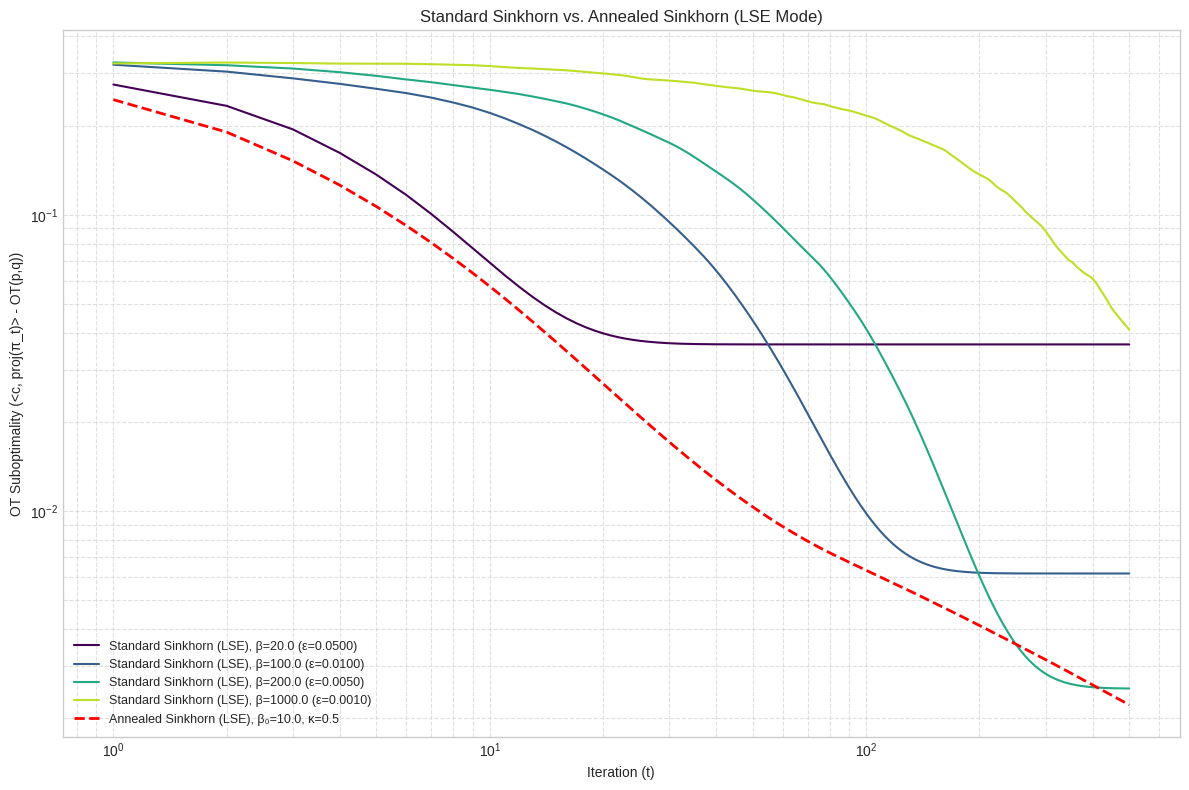

In [ ]:
# --- Function for Annealed Sinkhorn (Manual LSE Mode) ---
def run_annealed_sinkhorn_lse(
    p, q, cost_matrix, schedule_beta_fn, ot_cost_exact, max_iterations
    ):
    """Runs Annealed Sinkhorn in manual LSE mode."""
    suboptimalities = []
    m = p.shape[0]
    n = q.shape[0]
    dtype = cost_matrix.dtype

    # Initialize dual potentials
    f = jnp.zeros(m, dtype=dtype)
    g = jnp.zeros(n, dtype=dtype)

    # Precompute log marginals
    log_p = jnp.log(jnp.where(p > 0, p, 1.0))
    log_q = jnp.log(jnp.where(q > 0, q, 1.0))

    print("Running Annealed LSE Mode using manual logsumexp")

    for t in range(max_iterations):
        # Get beta and epsilon for iteration t
        beta_t = schedule_beta_fn(t)
        # Ensure epsilon_t doesn't become zero or negative if beta_t is huge
        epsilon_t = jnp.maximum(1.0 / beta_t, 1e-10)

        # Manual LSE Sinkhorn updates (order: g -> f)
        # Using stable logsumexp from jax.scipy

        # 1. Update g: g_new = -epsilon_t * logsumexp_i ( (f_i - C_ij) / epsilon_t ) + epsilon_t * log(q_j)
        term_g = (f[:, None] - cost_matrix) / epsilon_t
        lse_g = epsilon_t * jsp.special.logsumexp(term_g, axis=0) # The log-sum-exp part
        g_new = epsilon_t * log_q - lse_g                         # Add the marginal term

        # 2. Update f: f_new = -epsilon_t * logsumexp_j ( (g_new_j - C_ij) / epsilon_t ) + epsilon_t * log(p_i)
        term_f = (g_new[None, :] - cost_matrix) / epsilon_t
        lse_f = epsilon_t * jsp.special.logsumexp(term_f, axis=1) # The log-sum-exp part
        f_new = epsilon_t * log_p - lse_f                         # Add the marginal term

        # Assign new potentials
        f, g = f_new, g_new

        # --- Calculate suboptimality ---
        # Calculate current transport plan: pi_t = exp((f_i + g_j - C_ij) / epsilon_t)
        pi_t = jnp.exp((f[:, None] + g[None, :] - cost_matrix) / epsilon_t)

        # Project pi_t
        pi_t_proj = project_plan(pi_t, p, q)

        # Calculate projected cost
        cost_proj_t = jnp.sum(pi_t_proj * cost_matrix)

        # Calculate suboptimality
        subopt_t = cost_proj_t - ot_cost_exact
        suboptimalities.append(jnp.maximum(subopt_t, 1e-12))

    return jnp.array(suboptimalities)

# --- Define the Annealing Schedule ---
beta0_schedule = 10.0 # Fixed value as used in the paper's experiments
kappa_annealed = 0.5 # Optimal kappa for standard annealing

def schedule_concave(t, beta0=beta0_schedule, kappa=kappa_annealed):
  """ Concave schedule: beta_t = beta_0 * (t + 1)^kappa """
  # Handle t=-1 case needed for debiasing initialization later
  if t < 0:
      return beta0 # Return beta at t=0
  return beta0 * ((t + 1) ** kappa)

# --- Run Annealed Sinkhorn ---
print("\nRunning Annealed Sinkhorn...")
subopts_annealed = run_annealed_sinkhorn_lse(
    p=p_jax,
    q=q_jax,
    cost_matrix=cost_matrix_jax,
    schedule_beta_fn=schedule_concave,
    ot_cost_exact=ot_cost_exact,
    max_iterations=num_iterations_plot 
)

# --- Combined Plotting ---
plt.figure(figsize=(12, 8))
colors_standard = plt.cm.viridis(np.linspace(0, 0.9, len(epsilons_standard)))

# Plot Standard Sinkhorn results again
for i, eps_float in enumerate(results_standard.keys()):
    beta_val = 1.0 / eps_float
    plt.plot(
        range(1, num_iterations_plot + 1),
        results_standard[eps_float],
        linestyle='-',
        linewidth=1.5,
        color=colors_standard[i],
        label=f'Standard Sinkhorn (LSE), β={beta_val:.1f} (ε={eps_float:.4f})'
    )

# Plot Annealed Sinkhorn results
plt.plot(
    range(1, num_iterations_plot + 1),
    subopts_annealed,
    linestyle='--',
    linewidth=2.0,
    color='red',
    label=f'Annealed Sinkhorn (LSE), β₀={beta0_schedule:.1f}, κ={kappa_annealed}'
)


plt.xscale('log')
plt.yscale('log')
plt.xlabel('Iteration (t)')
plt.ylabel('OT Suboptimality (<c, proj(π_t)> - OT(p,q))')
plt.title(f'Standard Sinkhorn vs. Annealed Sinkhorn (LSE Mode)')
plt.legend(fontsize=9)
plt.grid(True, which="both", ls="--", alpha=0.6)
plt.tight_layout()
plt.show()

We observe that the Annealed Sinkhorn curve (with $\kappa=0.5$) starts relatively fast (like a large `epsilon` run) and gradually improves its accuracy, eventually crossing some of the standard Sinkhorn curves. However, its convergence rate appears limited, consistent with the theoretical $\mathcal{O}(t^{-1/2})$ rate, and it doesn't necessarily beat the overall Pareto front established by running standard Sinkhorn with optimally tuned `epsilon` for each iteration budget.

## 4. Debiased Annealed Sinkhorn

The paper identifies the "relaxation error" $\mathcal{O}(\beta_t - \beta_{t-1})$ as a key limitation for standard annealing. To mitigate this, it proposes a **Debiased Annealed Sinkhorn** algorithm (Algorithm 3).

The core idea (Proposition 4.1) is to modify the updates to effectively cancel out the first-order term of the relaxation error. In the dual LSE formulation (which we are using manually), this translates to modifying the update for the dual potential $f$. Instead of using $\epsilon_t \log(p_i)$ in the update, we use $\epsilon_t (\log(p_i) + (\alpha_t / \beta_{t-1}) f_{i, t-1})$, where $\alpha_t = \beta_t - \beta_{t-1}$ and $f_{i, t-1}$ is the potential from the *previous* iteration.

This debiasing potentially allows for faster annealing schedules. The paper suggests that $\kappa = 2/3$ might be optimal for the debiased version, leading to a faster theoretical rate of $\mathcal{O}(t^{-2/3})$.

Let's implement this debiased version.


Running Debiased Annealed Sinkhorn...
Running Debiased Annealed LSE Mode using manual logsumexp


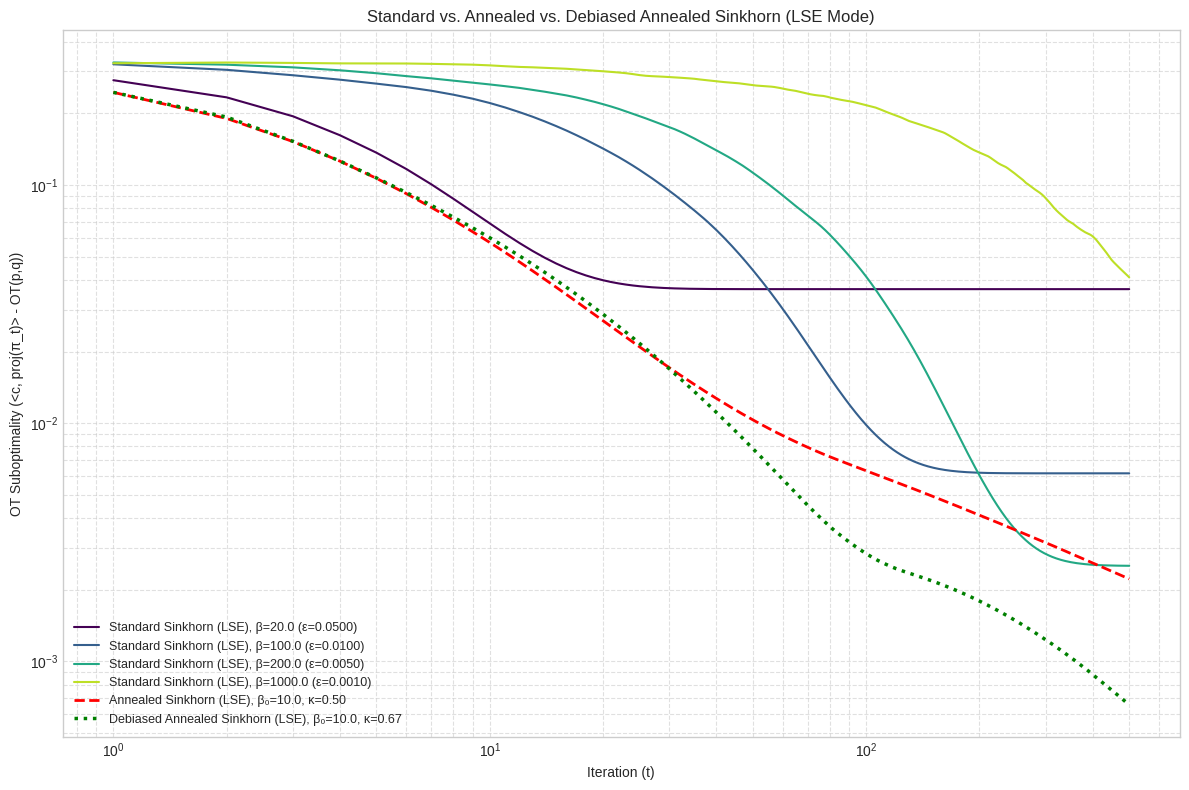

In [ ]:
# --- Function for Debiased Annealed Sinkhorn (Manual LSE Mode) ---
def run_debiased_annealed_sinkhorn_lse(
    p, q, cost_matrix, schedule_beta_fn, ot_cost_exact, max_iterations
    ):
    """Runs Debiased Annealed Sinkhorn in manual LSE mode."""
    suboptimalities = []
    m = p.shape[0]
    n = q.shape[0]
    dtype = cost_matrix.dtype

    # Initialize dual potentials
    f = jnp.zeros(m, dtype=dtype)
    g = jnp.zeros(n, dtype=dtype)

    # Precompute log marginals
    log_p = jnp.log(jnp.where(p > 0, p, 1.0))
    log_q = jnp.log(jnp.where(q > 0, q, 1.0))

    # Initialize beta_{t-1} for the first iteration (t=0)
    beta_prev = schedule_beta_fn(-1)

    print("Running Debiased Annealed LSE Mode using manual logsumexp")

    for t in range(max_iterations):
        # Get beta and epsilon for iteration t
        beta_t = schedule_beta_fn(t)
        epsilon_t = jnp.maximum(1.0 / beta_t, 1e-10)

        # Calculate alpha_t = beta_t - beta_{t-1}
        # Ensure beta_prev is not zero for division
        beta_prev_stable = jnp.maximum(beta_prev, 1e-6) # Add stability
        alpha_t = beta_t - beta_prev

        # Manual LSE Sinkhorn updates (order: g -> f)

        # 1. Update g (standard update, uses f_{t-1})
        term_g = (f[:, None] - cost_matrix) / epsilon_t
        lse_g = epsilon_t * jsp.special.logsumexp(term_g, axis=0)
        g_new = epsilon_t * log_q - lse_g

        # 2. Calculate the debiasing term and modified log(p)
        # Debiasing term: (alpha_t / beta_{t-1}) * f_{t-1}
        debias_term = (alpha_t / beta_prev_stable) * f
        log_p_modified = log_p + debias_term

        # 3. Update f (uses g_new and log_p_modified)
        term_f = (g_new[None, :] - cost_matrix) / epsilon_t
        lse_f = epsilon_t * jsp.special.logsumexp(term_f, axis=1)
        f_new = epsilon_t * log_p_modified - lse_f

        # Assign new potentials and update beta_prev for next iteration
        f, g = f_new, g_new
        beta_prev = beta_t

        # --- Calculate suboptimality ---
        pi_t = jnp.exp((f[:, None] + g[None, :] - cost_matrix) / epsilon_t)
        pi_t_proj = project_plan(pi_t, p, q)
        cost_proj_t = jnp.sum(pi_t_proj * cost_matrix)
        subopt_t = cost_proj_t - ot_cost_exact
        suboptimalities.append(jnp.maximum(subopt_t, 1e-12))

    return jnp.array(suboptimalities)


# --- Define Annealing Schedule with kappa=2/3 ---
kappa_debiased = 2/3 

# We can reuse schedule_concave by passing the kappa
def schedule_debiased_optimal(t, beta0=beta0_schedule, kappa=kappa_debiased):
    """ Schedule with kappa=2/3 for Debiased Annealed Sinkhorn. """
    # Handle t=-1 case needed for initialization
    if t < 0:
        return beta0 * ((0 + 1) ** kappa) # Return beta at t=0
    return beta0 * ((t + 1) ** kappa)


# --- Run Debiased Annealed Sinkhorn ---
print("\nRunning Debiased Annealed Sinkhorn...")
subopts_debiased_annealed = run_debiased_annealed_sinkhorn_lse(
    p=p_jax,
    q=q_jax,
    cost_matrix=cost_matrix_jax,
    schedule_beta_fn=schedule_debiased_optimal, # Use the kappa=2/3 schedule
    ot_cost_exact=ot_cost_exact,
    max_iterations=num_iterations_plot
)


# --- Final Combined Plotting ---
plt.figure(figsize=(12, 8))
colors_standard = plt.cm.viridis(np.linspace(0, 0.9, len(epsilons_standard)))

# Plot Standard Sinkhorn results
for i, eps_float in enumerate(results_standard.keys()):
    beta_val = 1.0 / eps_float
    plt.plot(
        range(1, num_iterations_plot + 1), results_standard[eps_float],
        linestyle='-', linewidth=1.5, color=colors_standard[i],
        label=f'Standard Sinkhorn (LSE), β={beta_val:.1f} (ε={eps_float:.4f})'
    )

# Plot Annealed Sinkhorn results
plt.plot(
    range(1, num_iterations_plot + 1), subopts_annealed,
    linestyle='--', linewidth=2.0, color='red',
    label=f'Annealed Sinkhorn (LSE), β₀={beta0_schedule:.1f}, κ={kappa_annealed:.2f}'
)

# Plot Debiased Annealed Sinkhorn results
plt.plot(
    range(1, num_iterations_plot + 1), subopts_debiased_annealed,
    linestyle=':', linewidth=2.5, color='green',
    label=f'Debiased Annealed Sinkhorn (LSE), β₀={beta0_schedule:.1f}, κ={kappa_debiased:.2f}'
)


plt.xscale('log')
plt.yscale('log')
plt.xlabel('Iteration (t)')
plt.ylabel('OT Suboptimality (<c, proj(π_t)> - OT(p,q))')
plt.title(f'Standard vs. Annealed vs. Debiased Annealed Sinkhorn (LSE Mode)')
plt.legend(fontsize=9)
plt.grid(True, which="both", ls="--", alpha=0.6)
plt.tight_layout()
plt.show()

This plot is the main result corresponding to Figure 1 in the paper. We observe that:
*   Debiased Annealed Sinkhorn (with $\kappa=2/3$) converges significantly faster than standard Annealed Sinkhorn (with $\kappa=1/2$).
*   Crucially, the debiased version's trajectory often approaches or even **beats** the Pareto front established by the standard Sinkhorn algorithm. This means a single run of Debiased Annealed Sinkhorn can potentially achieve better accuracy for a given iteration budget than any single run of standard Sinkhorn with a fixed `epsilon`.

## 5. Visualizing Transport Plans

Finally, let's visualize the actual transport plans $\pi$ obtained by the different methods after a fixed number of iterations. This gives a qualitative understanding of the solutions. We compare:
*   The exact EMD solution (sparse).
*   Standard Sinkhorn for different `beta` values (showing the effect of regularization).
*   Annealed Sinkhorn ($\kappa=0.5$).
*   Debiased Annealed Sinkhorn ($\kappa=2/3$).


Exact OT (EMD) plan calculated. Max value: 0.0083
Running Standard LSE for final plan (eps=0.0100)
  Max value in final plan: 0.0044
Running Standard LSE for final plan (eps=0.0050)
  Max value in final plan: 0.0063
Running Standard LSE for final plan (eps=0.0010)
  Max value in final plan: 0.0083
Running Annealed LSE for final plan
  Max value in final plan: 0.0082
Running Debiased Annealed LSE for final plan
  Max value in final plan: 0.0083


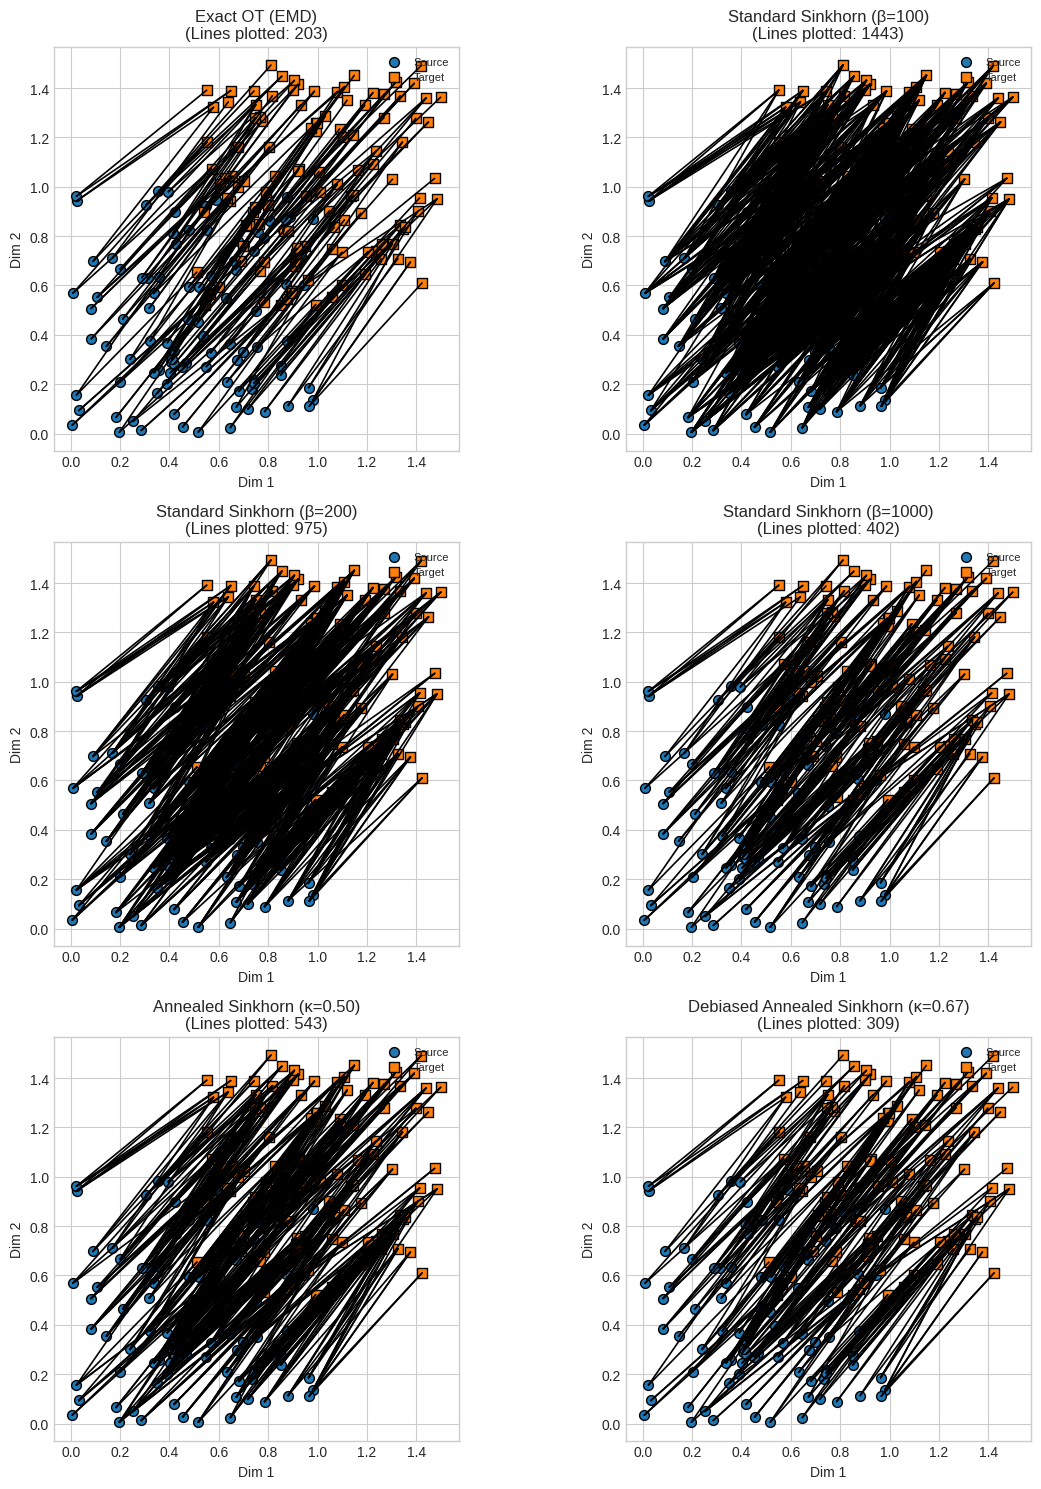

In [ ]:
# --- Modify runner functions to return the final transport plan ---
# (We only need the plan at the end, not the whole suboptimality trajectory)

def get_final_plan_standard(geom, p, q, max_iterations):
    """Runs standard LSE and returns the final plan pi_t."""
    m, n = geom.shape
    f = jnp.zeros(m, dtype=geom.dtype)
    g = jnp.zeros(n, dtype=geom.dtype)
    log_p = jnp.log(jnp.where(p > 0, p, 1.0))
    log_q = jnp.log(jnp.where(q > 0, q, 1.0))
    pi_t = jnp.zeros((m,n))

    print(f"Running Standard LSE for final plan (eps={geom.epsilon:.4f})")
    for t in range(max_iterations):
        g_new = geom.update_potential(f=f, g=g, log_marginal=log_q, iteration=t, axis=0)
        f_new = geom.update_potential(f=f, g=g_new, log_marginal=log_p, iteration=t, axis=1)
        f, g = f_new, g_new
        # Calculate pi_t only at the last iteration
        if t == max_iterations - 1:
           pi_t = geom.transport_from_potentials(f, g)
    print(f"  Max value in final plan: {pi_t.max():.4f}")
    return pi_t

def get_final_plan_annealed(p, q, cost_matrix, schedule_beta_fn, max_iterations):
    """Runs Annealed LSE and returns the final plan pi_t."""
    m = p.shape[0]; n = q.shape[0]; dtype = cost_matrix.dtype
    f = jnp.zeros(m, dtype=dtype); g = jnp.zeros(n, dtype=dtype)
    log_p = jnp.log(jnp.where(p > 0, p, 1.0)); log_q = jnp.log(jnp.where(q > 0, q, 1.0))
    pi_t = jnp.zeros((m,n))

    print("Running Annealed LSE for final plan")
    for t in range(max_iterations):
        beta_t = schedule_beta_fn(t)
        epsilon_t = jnp.maximum(1.0 / beta_t, 1e-10)
        term_g = (f[:, None] - cost_matrix) / epsilon_t
        lse_g = epsilon_t * jsp.special.logsumexp(term_g, axis=0)
        g_new = epsilon_t * log_q - lse_g
        term_f = (g_new[None, :] - cost_matrix) / epsilon_t
        lse_f = epsilon_t * jsp.special.logsumexp(term_f, axis=1)
        f_new = epsilon_t * log_p - lse_f
        f, g = f_new, g_new
        # Calculate pi_t only at the last iteration
        if t == max_iterations - 1:
            pi_t = jnp.exp((f[:, None] + g[None, :] - cost_matrix) / epsilon_t)
    print(f"  Max value in final plan: {pi_t.max():.4f}")
    return pi_t

def get_final_plan_debiased_annealed(p, q, cost_matrix, schedule_beta_fn, max_iterations):
    """Runs Debiased Annealed LSE and returns the final plan pi_t."""
    m = p.shape[0]; n = q.shape[0]; dtype = cost_matrix.dtype
    f = jnp.zeros(m, dtype=dtype); g = jnp.zeros(n, dtype=dtype)
    log_p = jnp.log(jnp.where(p > 0, p, 1.0)); log_q = jnp.log(jnp.where(q > 0, q, 1.0))
    beta_prev = schedule_beta_fn(-1)
    pi_t = jnp.zeros((m,n))

    print("Running Debiased Annealed LSE for final plan")
    for t in range(max_iterations):
        beta_t = schedule_beta_fn(t)
        beta_prev_stable = jnp.maximum(beta_prev, 1e-6)
        alpha_t = beta_t - beta_prev
        epsilon_t = jnp.maximum(1.0 / beta_t, 1e-10)
        term_g = (f[:, None] - cost_matrix) / epsilon_t
        lse_g = epsilon_t * jsp.special.logsumexp(term_g, axis=0)
        g_new = epsilon_t * log_q - lse_g
        debias_term = (alpha_t / beta_prev_stable) * f
        log_p_modified = log_p + debias_term
        term_f = (g_new[None, :] - cost_matrix) / epsilon_t
        lse_f = epsilon_t * jsp.special.logsumexp(term_f, axis=1)
        f_new = epsilon_t * log_p_modified - lse_f
        f, g = f_new, g_new
        beta_prev = beta_t
        # Calculate pi_t only at the last iteration
        if t == max_iterations - 1:
            pi_t = jnp.exp((f[:, None] + g[None, :] - cost_matrix) / epsilon_t)
    print(f"  Max value in final plan: {pi_t.max():.4f}")
    return pi_t

# --- Calculate Exact OT Plan (using POT) ---
pi_exact_np = ot.emd(p_np, q_np, cost_matrix_np)
print(f"\nExact OT (EMD) plan calculated. Max value: {pi_exact_np.max():.4f}")

# --- Get final plans from different methods ---
num_iterations_final_plot = 3000 

# Standard Sinkhorn for a few betas
beta_standard_100 = 100.0
eps_standard_100 = 1.0 / beta_standard_100
geom_standard_100 = pointcloud.PointCloud(x_data, y_data, epsilon=eps_standard_100, cost_matrix=cost_matrix_jax)
pi_standard_100 = get_final_plan_standard(geom_standard_100, p_jax, q_jax, num_iterations_final_plot)

beta_standard_200 = 200.0
eps_standard_200 = 1.0 / beta_standard_200
geom_standard_200 = pointcloud.PointCloud(x_data, y_data, epsilon=eps_standard_200, cost_matrix=cost_matrix_jax)
pi_standard_200 = get_final_plan_standard(geom_standard_200, p_jax, q_jax, num_iterations_final_plot)

beta_standard_1000 = 1000.0
eps_standard_1000 = 1.0 / beta_standard_1000
geom_standard_1000 = pointcloud.PointCloud(x_data, y_data, epsilon=eps_standard_1000, cost_matrix=cost_matrix_jax)
pi_standard_1000 = get_final_plan_standard(geom_standard_1000, p_jax, q_jax, num_iterations_final_plot)

# Annealed Sinkhorn
pi_annealed = get_final_plan_annealed(
    p=p_jax, q=q_jax, cost_matrix=cost_matrix_jax,
    schedule_beta_fn=schedule_concave,          # kappa=0.5
    max_iterations=num_iterations_final_plot
)

# Debiased Annealed Sinkhorn
pi_debiased = get_final_plan_debiased_annealed(
    p=p_jax, q=q_jax, cost_matrix=cost_matrix_jax,
    schedule_beta_fn=schedule_debiased_optimal, # kappa=2/3
    max_iterations=num_iterations_final_plot
)


# --- Plotting Function ---
def plot_ot_solution(ax, X_src, X_tgt, pi, title, threshold=1e-6, alpha_scale=500, color='black'):
    """Plots source/target points and transport lines based on plan pi."""
    ax.scatter(X_src[:, 0], X_src[:, 1], edgecolor="k", s = 50, marker='o', label='Source')
    ax.scatter(X_tgt[:, 0], X_tgt[:, 1], edgecolor="k", s = 50, marker='s', label='Target')

    # Normalize pi for alpha calculation (handle potential zero max)
    pi_max = jnp.max(pi)
    if pi_max <= 0: pi_max = 1.0 # Avoid division by zero

    # Iterate and draw lines for connections > threshold
    lines_drawn = 0
    pi_np = np.array(pi)
    for i in range(X_src.shape[0]):
        for j in range(X_tgt.shape[0]):
            if pi_np[i, j] > threshold:
                # Scale alpha relative to the max value in the plan
                alpha_val = jnp.minimum(1.0, pi_np[i, j] * alpha_scale / pi_max)
                ax.plot([X_src[i, 0], X_tgt[j, 0]],
                        [X_src[i, 1], X_tgt[j, 1]],
                        color=color, linewidth=1.2, alpha=float(alpha_val)) 
                lines_drawn +=1

    ax.set_title(f"{title}\n(Lines plotted: {lines_drawn})")
    ax.set_xlabel("Dim 1")
    ax.set_ylabel("Dim 2")
    ax.legend(loc='upper right', fontsize=8)
    ax.set_aspect('equal', adjustable='box')


# --- Create the Grid Plot ---
fig, axes = plt.subplots(3, 2, figsize=(12, 15))
axes = axes.ravel() # Flatten axes array for easy indexing

# 1. Plot Exact EMD Solution
# Use a smaller threshold for sparse EMD plan
plot_ot_solution(axes[0], x_data_np, y_data_np, pi_exact_np, "Exact OT (EMD)", threshold=1e-8, alpha_scale=m)

# 2. Plot Standard Sinkhorn (beta=100)
plot_ot_solution(axes[1], x_data_np, y_data_np, pi_standard_100, f"Standard Sinkhorn (β={beta_standard_100:.0f})", alpha_scale=m*2, threshold=5e-5) # Adjust threshold/alpha

# 3. Plot Standard Sinkhorn (beta=200)
plot_ot_solution(axes[2], x_data_np, y_data_np, pi_standard_200, f"Standard Sinkhorn (β={beta_standard_200:.0f})", alpha_scale=m*2, threshold=5e-5)

# 4. Plot Standard Sinkhorn (beta=1000 - closer to EMD)
plot_ot_solution(axes[3], x_data_np, y_data_np, pi_standard_1000, f"Standard Sinkhorn (β={beta_standard_1000:.0f})", alpha_scale=m*2, threshold=5e-5)

# 5. Plot Annealed Sinkhorn Solution
plot_ot_solution(axes[4], x_data_np, y_data_np, pi_annealed, f"Annealed Sinkhorn (κ={kappa_annealed:.2f})", alpha_scale=m*2, threshold=5e-5)

# 6. Plot Debiased Annealed Sinkhorn Solution
plot_ot_solution(axes[5], x_data_np, y_data_np, pi_debiased, f"Debiased Annealed Sinkhorn (κ={kappa_debiased:.2f})", alpha_scale=m*2, threshold=5e-5)


plt.tight_layout()
plt.show()

The visualizations illustrate:
*   The exact EMD plan is sparse, connecting only a few source-target pairs.
*   Standard Sinkhorn plans become sparser (closer to EMD) as `beta` increases (epsilon decreases), but even for large `beta`, they remain denser than EMD after a fixed number of iterations.
*   Annealed and Debiased Annealed Sinkhorn produce plans that are relatively sparse after `num_iterations_final_plot`, qualitatively similar to the high-`beta` standard Sinkhorn plan, but achieved through the annealing process. The number of lines plotted gives a rough idea of the plan's density/sparsity. Comparing the Annealed and Debiased plots visually might show subtle differences, but the main advantage of the debiased version lies in its faster *convergence* to such a plan, as seen in the previous section's plot.

## 6. Conclusion

This notebook explored the Annealed Sinkhorn algorithm and its debiased variant, based on the work of Chizat.

*   We reviewed the **speed-accuracy trade-off** inherent in the standard Sinkhorn algorithm controlled by the regularization parameter `epsilon`.
*   We implemented **Annealed Sinkhorn**, which uses a time-varying `beta_t` schedule. The analysis shows its convergence rate is limited, typically $\mathcal{O}(t^{-1/2})$ for the optimal concave schedule ($\kappa=1/2$).
*   We implemented the proposed **Debiased Annealed Sinkhorn**, which aims to mitigate the relaxation error. Experiments confirm the paper's findings: this variant allows for faster annealing schedules (e.g., $\kappa=2/3$) and achieves significantly faster convergence, often matching or exceeding the performance Pareto front of standard Sinkhorn.
*   Note that the **Symmetric Sinkhorn** and its debiased annealed version, discussed in Section 5 of the paper (Algorithm 4), were **not implemented** in this tutorial. The analysis and debiasing technique can be adapted to that case as well.

The debiasing technique provides a practical way to improve the performance of annealed Sinkhorn methods for solving Optimal Transport problems.